<a href="https://colab.research.google.com/github/tsenga2/keio-senga-seminar/blob/main/KahleStulz2017_F5_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**データの準備**
---

Google Drive のファイルを読み込む準備

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

pandasで読み込む準備

In [2]:
import pandas as pd
pd.set_option('display.max_columns', 100)

ファイルをダウンロード

In [3]:
fileDownloaded = drive.CreateFile({'id': '1FVoeneIcUooMRVRbaz5ntyq4URWcw1x-'})
fileDownloaded.GetContentFile('sample.csv')

# データの整理

pandasで読み込み不要な列を削除

In [4]:
df = pd.read_csv('sample.csv',encoding = "cp932")
df = df.drop(columns={'企業名称'})
df = df.drop(columns={'決算種別'})
df = df.drop(columns={'連結基準'})

名前の変更

In [5]:
df = df.rename(columns={'日経会社コード':'gvkey'})
df = df.rename(columns={'株式コード':'sc'})
df = df.rename(columns={'決算期':'fy'})
df = df.rename(columns={'<株主資本等変動計算書>【純資産合計／資本】剰余金の配当(百万円)[G130]':'ssdvc'})
df = df.rename(columns={'<【更新中止】利益処分計算書（単独）>普通株式配当金(百万円)[L015]':'asdvc'})
df = df.rename(columns={'<株主資本等変動計算書>【純資産合計／資本】自己株式の取得(百万円)[G132]':'ssprst'})
df = df.rename(columns={'<貸借対照表（資産）>資産合計(百万円)[B110]':'ta'})
df = df.rename(columns={'<損益計算書（期首からの累計期間）>親会社株主に帰属する当期純利益（連結）／当期利益（単独）［累計］(百万円)[D110]':'ni'})
df = df.rename(columns={'<基本項目>配当性向［累計］(％)[A065]':'dpp'})

データ上、S/Sのdvcとprstは、配当または自己株式取得をした場合に負となるため、正に直す

In [6]:
df['ssdvc'] = df['ssdvc'] * -1
df['ssprst'] = df['ssprst'] * -1

In [7]:
df['dpp'] = df['dpp']/100

S/SのTotal Payoutを計算

sstp = ssdvc + ssprst

In [8]:
df['sstp'] = df['ssdvc'] + df['ssprst']
df = df.reindex(columns=['fy', 'gvkey', 'sc', 'asdvc', 'ssdvc', 'ssprst', 'sstp', 'ta', 'ni', 'dpp'])

fy列の最後の2文字を取り出して西暦に直し、indexにする。

In [9]:
df['fy'] = df['fy'].str[-2:]
df['fy'] = df['fy'].astype(int)

In [10]:
for i in range(len(df)):
   if df.loc[i,'fy'] >= 75 :
     df.loc[i,'fy'] = 1900 + df.loc[i,'fy']
   else : df.loc[i,'fy'] = 2000 + df.loc[i,'fy']

In [11]:
df = df.set_index('fy')

グラフ項目の計算

In [12]:
df['asdvc/ni'] = df['asdvc']/df['ni']
df['asdvc/ta'] = df['asdvc']/df['ta']

df['ssdvc/ni'] = df['ssdvc']/df['ni']
df['sstp/ni'] = df['sstp']/df['ni']
df['ssdvc/ta'] = df['ssdvc']/df['ta']
df['ssprst/ta'] = df['ssprst']/df['ta']
df['sstp/ta'] = df['sstp']/df['ta']

# データの確認

In [13]:
df.head()

,gvkey,sc,asdvc,ssdvc,ssprst,sstp,ta,ni,dpp,asdvc/ni,asdvc/ta,ssdvc/ni,sstp/ni,ssdvc/ta,ssprst/ta,sstp/ta
fy,,,,,,,,,,,,,,,,
1975,322,3116,NaN,NaN,NaN,NaN,15957,-1719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976,322,3116,NaN,NaN,NaN,NaN,17844,1214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977,322,3116,NaN,NaN,NaN,NaN,17309,305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,322,3116,NaN,NaN,NaN,NaN,13411,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,322,3116,250.0,NaN,NaN,NaN,13843,962,NaN,0.259875,0.01806,NaN,NaN,NaN,NaN,NaN


In [14]:
df.describe()

,gvkey,sc,asdvc,ssdvc,ssprst,sstp,ta,ni,dpp,asdvc/ni,asdvc/ta,ssdvc/ni,sstp/ni,ssdvc/ta,ssprst/ta,sstp/ta
count,1840.000000,1840.000000,1412.000000,394.000000,266.000000,241.000000,1.840000e+03,1.840000e+03,294.000000,1412.000000,1412.000000,394.000000,241.000000,394.000000,2.660000e+02,241.000000
mean,6829.551087,6897.473913,2610.599858,14811.961929,6280.842105,29733.294606,4.280786e+05,1.360867e+04,0.525941,0.188759,0.004769,-0.223803,-0.267337,0.011658,5.078837e-03,0.017683
std,11605.900768,975.020003,12972.739230,56607.650852,37062.681266,101577.577811,1.218138e+06,8.633920e+04,0.870491,1.668081,0.002720,6.320087,8.284302,0.009396,1.671395e-02,0.017720
min,322.000000,3116.000000,10.000000,33.000000,1.000000,72.000000,3.293000e+03,-7.900640e+05,-4.218000,-55.741379,0.000496,-111.517241,-112.551724,0.000498,5.735369e-07,0.001311
25%,1372.000000,7203.000000,108.750000,342.000000,3.000000,804.000000,2.888875e+04,4.350000e+02,0.207500,0.116374,0.003074,0.118020,0.123403,0.005910,1.435010e-05,0.007342
50%,1389.000000,7242.000000,224.000000,931.500000,9.000000,2747.000000,6.262250e+04,1.184000e+03,0.331200,0.174407,0.004253,0.256998,0.269403,0.008745,4.354528e-05,0.011674
75%,12206.000000,7270.000000,691.000000,3530.500000,196.500000,7719.000000,2.288902e+05,4.497000e+03,0.513000,0.283438,0.005580,0.414234,0.625575,0.013645,7.390140e-04,0.020155
max,91029.000000,7313.000000,236195.000000,554932.000000,359872.000000,914804.000000,1.512862e+07,1.690679e+06,6.729000,6.493671,0.029791,9.156069,19.369748,0.057309,1.754990e-01,0.140236


asdvc、ssdvcは正になっており、無配当のデータはない。

# グラフ作成

各年ごとの平均データを作成

In [15]:
df = df[['asdvc/ni', 'asdvc/ta', 'ssdvc/ni', 'sstp/ni', 'ssdvc/ta', 'ssprst/ta', 'sstp/ta', 'dpp']].mean(level=0)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  """Entry point for launching an IPython kernel.


,asdvc/ni,asdvc/ta,ssdvc/ni,sstp/ni,ssdvc/ta,ssprst/ta,sstp/ta,dpp
fy,,,,,,,,
1975,0.532285,0.006056,NaN,NaN,NaN,NaN,NaN,NaN
1976,0.314812,0.006190,NaN,NaN,NaN,NaN,NaN,NaN
1977,0.239203,0.005947,NaN,NaN,NaN,NaN,NaN,NaN
1978,0.215813,0.005593,NaN,NaN,NaN,NaN,NaN,NaN
1979,0.193110,0.006208,NaN,NaN,NaN,NaN,NaN,NaN
1980,0.188280,0.006125,NaN,NaN,NaN,NaN,NaN,NaN
1981,0.199960,0.005610,NaN,NaN,NaN,NaN,NaN,NaN
1982,0.224288,0.005353,NaN,NaN,NaN,NaN,NaN,NaN
1983,0.404491,0.005148,NaN,NaN,NaN,NaN,NaN,NaN


グラフ作成ライブラリを読み込む

In [16]:
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

使用可能なグラフスタイルを一覧表示

In [17]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

グラフスタイルを選択

In [18]:
plt.style.use('ggplot')

A. The Ratio of Total Payout to Net Income

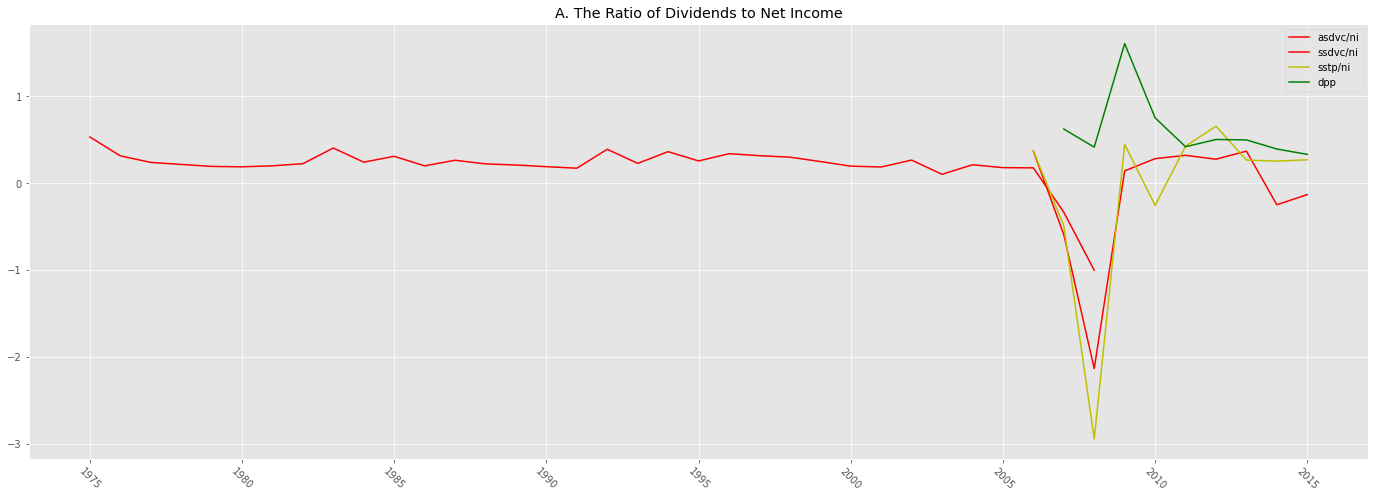

In [19]:
df[['asdvc/ni', 'ssdvc/ni', 'sstp/ni', 'dpp']].plot.line(
    title='A. The Ratio of Dividends to Net Income', 
    color = ("r", "r", "y","g") , xlabel = "", figsize=(24, 8), rot=-45)

B. Dividends, Reparchases, and Total Payout (All as a Fraction of Toatal Assets)

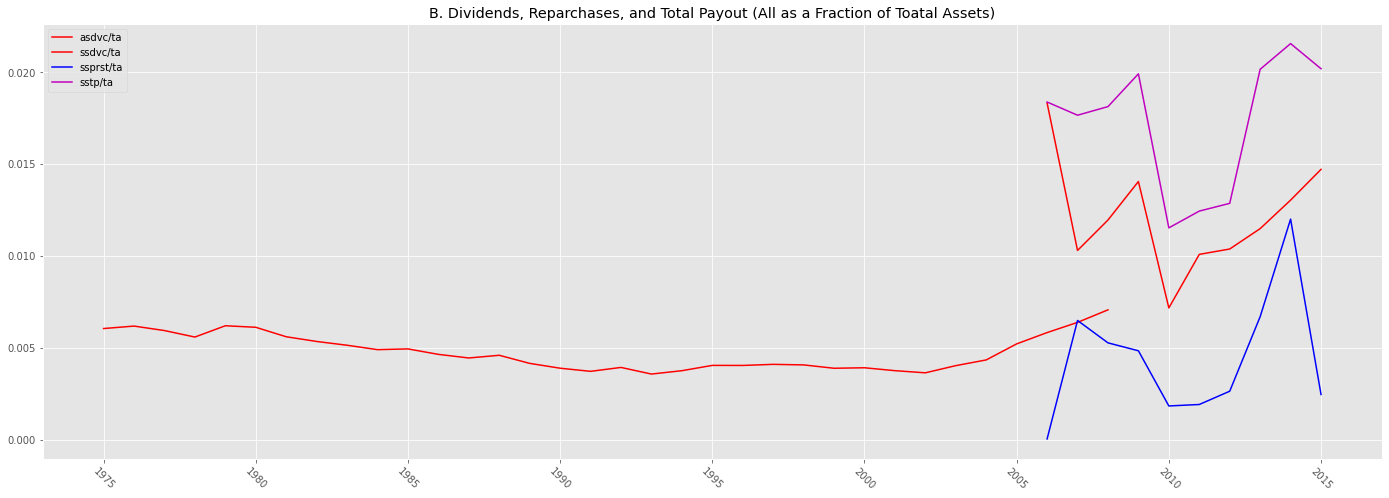

In [20]:
df[['asdvc/ta', 'ssdvc/ta', 'ssprst/ta', 'sstp/ta']].plot.line(
     title='B. Dividends, Reparchases, and Total Payout (All as a Fraction of Toatal Assets)', 
     color = ("r", "r", "b", "m"), xlabel = "", figsize=(24, 8), rot=-45)

# 項目名略称一覧

日経会社コード　gvkey

株式コード　sc

決算期　fy

**利益処分計算書**

　普通株式配当金　asdvc　（配当したら正）

**株主資本計算書**

　剰余金の配当　ssdvc　（配当したら負）

　自己株式の取得　ssprst　（自己株式取得したら負）

**P/L**

　利益　ni

**B/S**

　総資産　ta

**基本項目**　

　配当性向　dpr
